<a href="https://colab.research.google.com/github/YahyaHajji/AI_Emotion_Detection_CNN/blob/master/emotion_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import Required Libraries**

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("✅ Libraries imported successfully!")

**Step 2: Download and Prepare FER2013 Dataset:**

In [ ]:
# Download FER2013 dataset from Kaggle
# You'll need to upload your kaggle.json file or use the dataset directly

# Method 1: Upload kaggle.json for Kaggle API
from google.colab import files
print("📁 Upload your kaggle.json file (get it from Kaggle → Account → API)")
print("   If you don't have it, go to: https://www.kaggle.com/account")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip

print("✅ Dataset downloaded and extracted!")

In [ ]:
# Define emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
num_classes = len(emotion_labels)

# Check dataset structure
import os
train_dir_base = 'train'
test_dir_base = 'test'

print("📊 Dataset Structure:")
print("="*60)

total_train = 0
if os.path.exists(train_dir_base):
    for emotion in emotion_labels:
        train_path = os.path.join(train_dir_base, emotion)
        if os.path.exists(train_path):
            count = len(os.listdir(train_path))
            print(f"{emotion:12s}: {count:5d} training images")
            total_train += count
else:
    print(f"⚠️ Training directory '{train_dir_base}' not found.")

print("-"*60)

total_test = 0
if os.path.exists(test_dir_base):
    for emotion in emotion_labels:
        test_path = os.path.join(test_dir_base, emotion)
        if os.path.exists(test_path):
            count = len(os.listdir(test_path))
            print(f"{emotion:12s}: {count:5d} test images")
            total_test += count
else:
    print(f"⚠️ Test directory '{test_dir_base}' not found.")

print("="*60)

print(f"\nTotal training images: {total_train}")
print(f"Total test images: {total_test}")

In [ ]:
# Visualize sample images from each emotion class
fig, axes = plt.subplots(4, 7, figsize=(20, 12))

for i, emotion in enumerate(emotion_labels):
    emotion_path = os.path.join(train_dir, emotion)
    if os.path.exists(emotion_path):
        images = os.listdir(emotion_path)[:4]  # Get first 4 images

        for j, img_name in enumerate(images):
            img_path = os.path.join(emotion_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            axes[j, i].imshow(img, cmap='gray')
            axes[j, i].axis('off')
            if j == 0:
                axes[j, i].set_title(emotion, fontsize=12, fontweight='bold')

plt.suptitle('Sample Images from Each Emotion Class', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
# Image parameters
img_size = 48  # FER2013 images are 48x48
batch_size = 64

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values
    rotation_range=20,                 # Random rotation
    width_shift_range=0.2,             # Horizontal shift
    height_shift_range=0.2,            # Vertical shift
    horizontal_flip=True,              # Random horizontal flip
    zoom_range=0.2,                    # Random zoom
    shear_range=0.2,                   # Shear transformation
    fill_mode='nearest',               # Fill empty pixels
    validation_split=0.2               # 20% for validation
)

# Only rescaling for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

print("✅ Data generators created successfully!")
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")

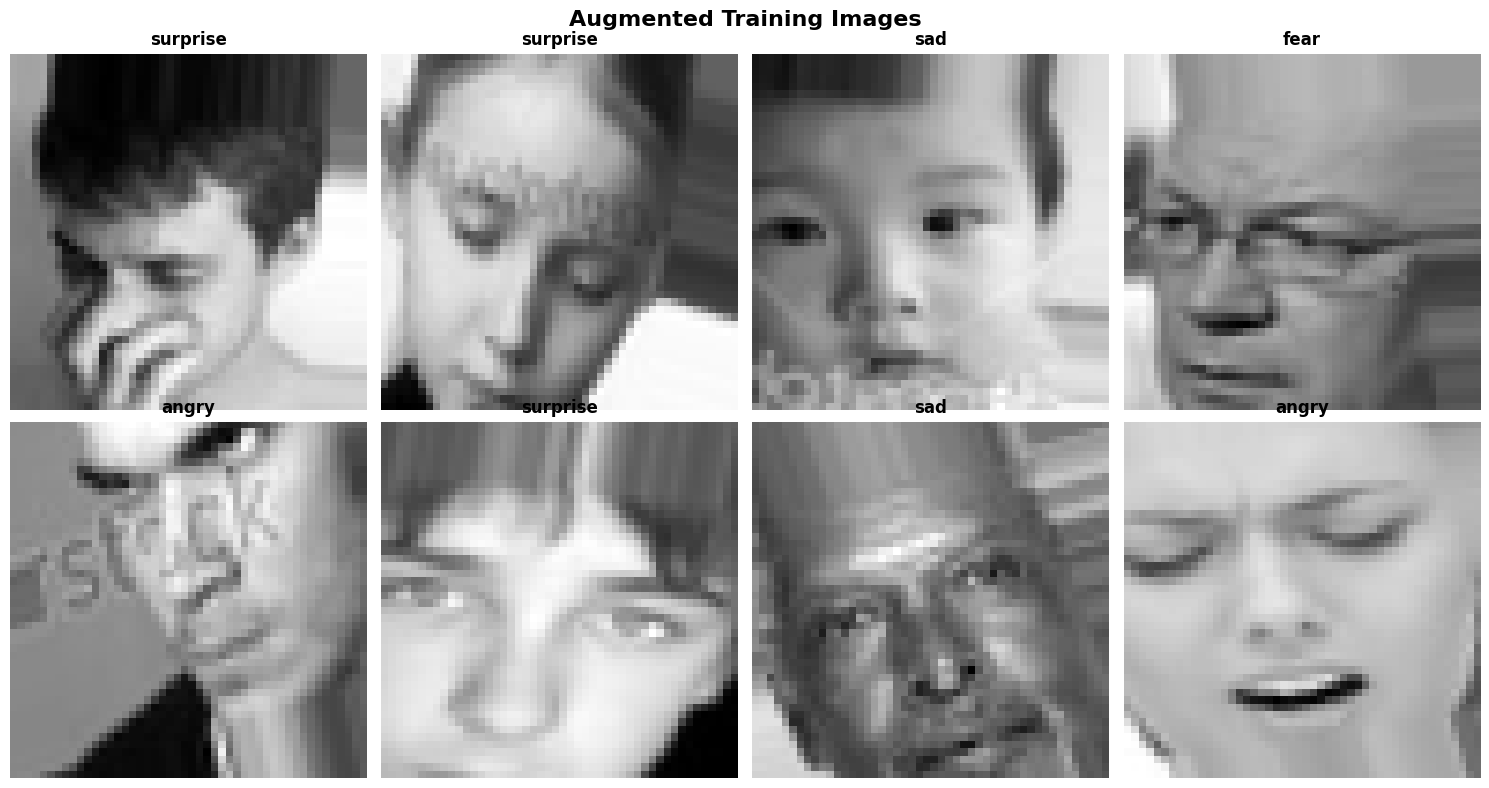

In [ ]:
# Visualize data augmentation
sample_batch = next(train_generator)
sample_images = sample_batch[0][:8]  # Get first 8 images
sample_labels = sample_batch[1][:8]

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    emotion_idx = np.argmax(sample_labels[i])
    axes[i].set_title(f'{emotion_labels[emotion_idx]}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Augmented Training Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Build Emotion Detection CNN
model = Sequential([
    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth Convolutional Block
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Display model architecture
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\n📊 Total parameters: {total_params:,}")

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print("\nModel Configuration:")
print(f"  • Optimizer: Adam")
print(f"  • Loss: Categorical Crossentropy")
print(f"  • Metrics: Accuracy")
print(f"  • Classes: {num_classes} emotions")

In [ ]:
# Define callbacks for better training
callbacks = [
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        'best_emotion_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✅ Callbacks configured:")
print("  • ReduceLROnPlateau: Reduces learning rate when stuck")
print("  • EarlyStopping: Stops training if no improvement")
print("  • ModelCheckpoint: Saves best model during training")

In [ ]:
# Train the model
print("🚀 Starting training...")
print("="*60)

epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\n📊 Final Training Metrics:")
print("="*60)
print(f"Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Training Loss:       {final_train_loss:.4f}")
print(f"Validation Loss:     {final_val_loss:.4f}")
print("="*60)

In [ ]:
# Evaluate on test set
print("🧪 Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\n" + "="*60)
print("📊 TEST SET EVALUATION")
print("="*60)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*60)

In [ ]:
# Generate predictions
print("🔮 Generating predictions...")

# Reset test generator
test_generator.reset()

# Get predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 10})
plt.title('Confusion Matrix - Emotion Detection', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Emotion', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Emotion', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels,
            cbar_kws={'label': 'Percentage'},
            annot_kws={'size': 10})
plt.title('Normalized Confusion Matrix - Emotion Detection', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Emotion', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Emotion', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Generate detailed classification report
print("\n📊 DETAILED CLASSIFICATION REPORT")
print("="*80)
report = classification_report(true_classes, predicted_classes,
                               target_names=emotion_labels,
                               digits=4)
print(report)
print("="*80)

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, average=None
)

# Create DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Emotion': emotion_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n📈 Per-Class Performance Metrics:")
print(metrics_df.to_string(index=False))

In [ ]:
# Visualize per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of per-class accuracy
colors = ['red' if acc < 0.6 else 'orange' if acc < 0.75 else 'green'
          for acc in class_accuracy]

bars = ax1.barh(emotion_labels, class_accuracy * 100, color=colors,
                edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, class_accuracy)):
    ax1.text(acc * 100 + 1, i, f'{acc*100:.1f}%',
             va='center', fontsize=11, fontweight='bold')

ax1.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 105])
ax1.grid(axis='x', alpha=0.3)

# F1-Score comparison
colors_f1 = ['red' if f1 < 0.6 else 'orange' if f1 < 0.75 else 'green'
             for f1 in f1]

bars2 = ax2.barh(emotion_labels, f1, color=colors_f1,
                 edgecolor='black', linewidth=1.5)

for i, (bar, f1_score) in enumerate(zip(bars2, f1)):
    ax2.text(f1_score + 0.01, i, f'{f1_score:.3f}',
             va='center', fontsize=11, fontweight='bold')

ax2.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('Per-Class F1-Score', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1.05])
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print("\n🎯 Performance Insights:")
print("="*60)
best_emotion = emotion_labels[np.argmax(class_accuracy)]
worst_emotion = emotion_labels[np.argmin(class_accuracy)]
print(f"Best performing: {best_emotion} ({class_accuracy.max()*100:.2f}%)")
print(f"Worst performing: {worst_emotion} ({class_accuracy.min()*100:.2f}%)")
print(f"Average accuracy: {class_accuracy.mean()*100:.2f}%")
print("="*60)

In [ ]:
# Get sample predictions
test_generator.reset()
sample_images, sample_labels = next(test_generator)
sample_predictions = model.predict(sample_images)

# Find correct and incorrect predictions
correct_indices = []
incorrect_indices = []

for i in range(len(sample_predictions)):
    true_label = np.argmax(sample_labels[i])
    pred_label = np.argmax(sample_predictions[i])

    if true_label == pred_label:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

# Visualize correct predictions
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.ravel()

for i, idx in enumerate(correct_indices[:15]):
    axes[i].imshow(sample_images[idx].squeeze(), cmap='gray')
    true_label = np.argmax(sample_labels[idx])
    pred_label = np.argmax(sample_predictions[idx])
    confidence = sample_predictions[idx][pred_label] * 100

    axes[i].set_title(f'True: {emotion_labels[true_label]}\n'
                     f'Pred: {emotion_labels[pred_label]}\n'
                     f'Conf: {confidence:.1f}%',
                     color='green', fontsize=9, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Correct Predictions ✓', fontsize=16, fontweight='bold', color='green')
plt.tight_layout()
plt.show()

# Visualize incorrect predictions
if len(incorrect_indices) > 0:
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    axes = axes.ravel()

    for i, idx in enumerate(incorrect_indices[:15]):
        if i >= 15:
            break
        axes[i].imshow(sample_images[idx].squeeze(), cmap='gray')
        true_label = np.argmax(sample_labels[idx])
        pred_label = np.argmax(sample_predictions[idx])
        confidence = sample_predictions[idx][pred_label] * 100

        axes[i].set_title(f'True: {emotion_labels[true_label]}\n'
                         f'Pred: {emotion_labels[pred_label]}\n'
                         f'Conf: {confidence:.1f}%',
                         color='red', fontsize=9, fontweight='bold')
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(len(incorrect_indices[:15]), 15):
        axes[i].axis('off')

    plt.suptitle('Incorrect Predictions ✗', fontsize=16, fontweight='bold', color='red')
    plt.tight_layout()
    plt.show()

In [ ]:
# Function for real-time emotion detection
def detect_emotion(image_path):
    """
    Detect emotion from a single image
    """
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (48, 48))
    img_normalized = img_resized / 255.0
    img_reshaped = img_normalized.reshape(1, 48, 48, 1)

    # Predict
    prediction = model.predict(img_reshaped, verbose=0)
    emotion_idx = np.argmax(prediction)
    emotion = emotion_labels[emotion_idx]
    confidence = prediction[0][emotion_idx] * 100

    # Visualize
    plt.figure(figsize=(10, 5))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Input Image', fontsize=12, fontweight='bold')
    plt.axis('off')

    # Show prediction probabilities
    plt.subplot(1, 2, 2)
    bars = plt.barh(emotion_labels, prediction[0] * 100,
                    color=['green' if i == emotion_idx else 'lightgray'
                          for i in range(len(emotion_labels))],
                    edgecolor='black', linewidth=1.5)
    plt.xlabel('Confidence (%)', fontsize=12, fontweight='bold')
    plt.title('Emotion Probabilities', fontsize=12, fontweight='bold')
    plt.xlim([0, 100])
    plt.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n🎭 Detected Emotion: {emotion}")
    print(f"📊 Confidence: {confidence:.2f}%")

    return emotion, confidence

# Test with a sample image
sample_test_path = os.path.join(test_dir, emotion_labels[0], os.listdir(os.path.join(test_dir, emotion_labels[0]))[0])
if os.path.exists(sample_test_path):
    detect_emotion(sample_test_path)

In [ ]:
# Save the model
model.save('emotion_detection_model.h5')
print("✅ Model saved as 'emotion_detection_model.h5'")

# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/emotion_detection_model.h5'
model.save(drive_path)
print(f"✅ Model also saved to Google Drive: {drive_path}")

# Save training history
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✅ Training history saved")

# Create model info file
model_info = {
    'architecture': 'CNN',
    'input_shape': (48, 48, 1),
    'num_classes': num_classes,
    'emotions': emotion_labels,
    'test_accuracy': float(test_accuracy),
    'total_parameters': total_params,
    'epochs_trained': len(history.history['loss'])
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
print("✅ Model information saved")

In [ ]:
# Example: How to load and use the saved model later
from tensorflow.keras.models import load_model

# Load model
loaded_model = load_model('emotion_detection_model.h5')
print("✅ Model loaded successfully!")

# Test prediction with loaded model
test_generator.reset()
test_sample = next(test_generator)[0][:5]
predictions = loaded_model.predict(test_sample)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(test_sample[i].squeeze(), cmap='gray')
    pred_emotion = emotion_labels[np.argmax(predictions[i])]
    confidence = predictions[i].max() * 100
    axes[i].set_title(f'{pred_emotion}\n{confidence:.1f}%',
                     fontsize=10, fontweight='bold')
    axes[i].axis('off')
plt.suptitle('Loaded Model Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize model architecture
from tensorflow.keras.utils import plot_model

plot_model(model,
           to_file='emotion_detection_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',  # Top to Bottom
           dpi=96)

from IPython.display import Image
Image('emotion_detection_architecture.png')

In [ ]:
# Create comprehensive performance dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Training History - Accuracy
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(history.history['accuracy'], label='Training', linewidth=2, color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='orange')
ax1.set_title('Training & Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Training History - Loss
ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(history.history['loss'], label='Training', linewidth=2, color='blue')
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2, color='orange')
ax2.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Per-Class Accuracy
ax3 = fig.add_subplot(gs[0, 2])
colors = plt.cm.RdYlGn(class_accuracy)
ax3.barh(emotion_labels, class_accuracy * 100, color=colors, edgecolor='black')
ax3.set_xlabel('Accuracy (%)')
ax3.set_title('Per-Class Accuracy', fontsize=12, fontweight='bold')
ax3.set_xlim([0, 100])
ax3.grid(axis='x', alpha=0.3)

# 4. Class Distribution (continued)
ax4 = fig.add_subplot(gs[1, 2])
class_counts = [cm[i].sum() for i in range(len(emotion_labels))]
ax4.pie(class_counts, labels=emotion_labels, autopct='%1.1f%%',
        startangle=90, colors=plt.cm.Set3.colors)
ax4.set_title('Test Set Distribution', fontsize=12, fontweight='bold')

# 5. Confusion Matrix Heatmap
ax5 = fig.add_subplot(gs[2, :])
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=emotion_labels, yticklabels=emotion_labels,
            ax=ax5, cbar_kws={'label': 'Percentage'})
ax5.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax5.set_ylabel('True Emotion')
ax5.set_xlabel('Predicted Emotion')

plt.suptitle('Emotion Detection Model - Performance Dashboard',
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('performance_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Performance dashboard saved as 'performance_dashboard.png'")

In [ ]:
# Analyze most confused emotion pairs
confusion_pairs = []

for i in range(len(emotion_labels)):
    for j in range(len(emotion_labels)):
        if i != j:
            # Normalized confusion (percentage)
            confusion_rate = cm_normalized[i, j]
            if confusion_rate > 0.05:  # At least 5% confusion
                confusion_pairs.append({
                    'True': emotion_labels[i],
                    'Predicted': emotion_labels[j],
                    'Count': cm[i, j],
                    'Rate': confusion_rate * 100
                })

# Sort by confusion rate
confusion_pairs.sort(key=lambda x: x['Rate'], reverse=True)

print("\n🔀 Most Confused Emotion Pairs (>5% confusion):")
print("="*70)
print(f"{'True Emotion':<15} {'Predicted As':<15} {'Count':<10} {'Rate (%)':<10}")
print("-"*70)
for pair in confusion_pairs[:10]:
    print(f"{pair['True']:<15} {pair['Predicted']:<15} {pair['Count']:<10} {pair['Rate']:.2f}")
print("="*70)

# Visualize most confused pairs
if len(confusion_pairs) > 0:
    top_confusions = confusion_pairs[:6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, pair in enumerate(top_confusions):
        true_emotion = pair['True']
        pred_emotion = pair['Predicted']

        # Find examples of this confusion
        true_idx = emotion_labels.index(true_emotion)
        pred_idx = emotion_labels.index(pred_emotion)

        confused_samples = []
        test_generator.reset()

        # Search through test set
        for batch_idx in range(len(test_generator)):
            batch_images, batch_labels = test_generator[batch_idx]
            batch_preds = model.predict(batch_images, verbose=0)

            for i in range(len(batch_labels)):
                true_label = np.argmax(batch_labels[i])
                pred_label = np.argmax(batch_preds[i])

                if true_label == true_idx and pred_label == pred_idx:
                    confused_samples.append(batch_images[i])
                    if len(confused_samples) >= 1:
                        break

            if len(confused_samples) >= 1:
                break

        if confused_samples:
            axes[idx].imshow(confused_samples[0].squeeze(), cmap='gray')
            axes[idx].set_title(f'True: {true_emotion}\n→ Predicted: {pred_emotion}\n({pair["Rate"]:.1f}%)',
                              fontsize=10, fontweight='bold', color='red')
            axes[idx].axis('off')
        else:
            axes[idx].axis('off')

    plt.suptitle('Most Common Misclassifications', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
# Implement Grad-CAM to visualize what the model focuses on
import tensorflow as tf
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap
    """
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the output neuron with regard to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by "how important this channel is"
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    """
    Superimpose the heatmap on original image
    """
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    if len(img.shape) == 2:  # Grayscale
        img = np.stack([img] * 3, axis=-1)

    superimposed_img = jet_heatmap * alpha + img * 255 * (1 - alpha)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# Find the name of the last convolutional layer
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"Last convolutional layer: {last_conv_layer_name}")

# Generate Grad-CAM for sample images
test_generator.reset()
sample_batch = next(test_generator)
sample_images = sample_batch[0][:6]
sample_labels = sample_batch[1][:6]

fig, axes = plt.subplots(3, 6, figsize=(18, 10))

for i in range(6):
    # Original image
    axes[0, i].imshow(sample_images[i].squeeze(), cmap='gray')
    true_label = emotion_labels[np.argmax(sample_labels[i])]
    axes[0, i].set_title(f'Original\n{true_label}', fontsize=9, fontweight='bold')
    axes[0, i].axis('off')

    # Prediction
    pred = model.predict(sample_images[i:i+1], verbose=0)
    pred_label = emotion_labels[np.argmax(pred)]
    confidence = pred[0].max() * 100

    # Generate Grad-CAM
    heatmap = make_gradcam_heatmap(
        sample_images[i:i+1],
        model,
        last_conv_layer_name
    )

    # Display heatmap
    axes[1, i].imshow(heatmap, cmap='jet')
    axes[1, i].set_title('Attention\nHeatmap', fontsize=9, fontweight='bold')
    axes[1, i].axis('off')

    # Superimposed image
    superimposed = display_gradcam(sample_images[i].squeeze(), heatmap)
    axes[2, i].imshow(superimposed)
    axes[2, i].set_title(f'Pred: {pred_label}\n{confidence:.1f}%',
                        fontsize=9, fontweight='bold',
                        color='green' if pred_label == true_label else 'red')
    axes[2, i].axis('off')

plt.suptitle('Grad-CAM: What the Model Focuses On', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Grad-CAM visualization shows which regions of the face")
print("   the model focuses on for emotion detection")

In [ ]:
# Real-time webcam emotion detection (requires webcam access)
from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io

def take_photo(filename='photo.jpg', quality=0.8):
    """
    Take a photo using webcam in Colab
    """
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize video to fit screen
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for capture button click
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

# Function to detect emotion from webcam
def detect_emotion_webcam():
    """
    Capture photo from webcam and detect emotion
    """
    try:
        # Capture photo
        print("📸 Click 'Capture' button to take a photo...")
        filename = take_photo()

        # Load and preprocess
        img = cv2.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect face using Haar Cascade
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(faces) == 0:
            print("❌ No face detected! Try again with better lighting.")
            return

        # Get the first face
        (x, y, w, h) = faces[0]
        face_roi = gray[y:y+h, x:x+w]

        # Preprocess for model
        face_resized = cv2.resize(face_roi, (48, 48))
        face_normalized = face_resized / 255.0
        face_reshaped = face_normalized.reshape(1, 48, 48, 1)

        # Predict
        prediction = model.predict(face_reshaped, verbose=0)
        emotion_idx = np.argmax(prediction)
        emotion = emotion_labels[emotion_idx]
        confidence = prediction[0][emotion_idx] * 100

        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original image with face detection
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_rgb, f'{emotion}: {confidence:.1f}%',
                   (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        axes[0].imshow(img_rgb)
        axes[0].set_title('Face Detection', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Cropped face
        axes[1].imshow(face_roi, cmap='gray')
        axes[1].set_title('Extracted Face', fontsize=12, fontweight='bold')
        axes[1].axis('off')

        # Prediction probabilities
        axes[2].barh(emotion_labels, prediction[0] * 100,
                    color=['green' if i == emotion_idx else 'lightgray'
                          for i in range(len(emotion_labels))],
                    edgecolor='black', linewidth=1.5)
        axes[2].set_xlabel('Confidence (%)', fontsize=12, fontweight='bold')
        axes[2].set_title('Emotion Probabilities', fontsize=12, fontweight='bold')
        axes[2].set_xlim([0, 100])
        axes[2].grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\n🎭 Detected Emotion: {emotion}")
        print(f"📊 Confidence: {confidence:.2f}%")

        # Show all probabilities
        print("\n📋 All Emotion Probabilities:")
        for i, prob in enumerate(prediction[0]):
            print(f"   {emotion_labels[i]:12s}: {prob*100:5.2f}%")

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        print("💡 Note: Webcam access requires user permission in browser")

print("✅ Webcam emotion detection function ready!")
print("📸 Run: detect_emotion_webcam() to capture and analyze")

In [ ]:
# Convert model to TensorFlow Lite for mobile deployment
import tensorflow as tf

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save TFLite model
with open('emotion_detection.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ TensorFlow Lite model saved: emotion_detection.tflite")
print(f"   Original model size: {os.path.getsize('emotion_detection_model.h5') / 1024 / 1024:.2f} MB")
print(f"   TFLite model size: {len(tflite_model) / 1024 / 1024:.2f} MB")

# Save model in SavedModel format
tf.saved_model.save(model, 'emotion_detection_savedmodel')
print("✅ SavedModel format saved: emotion_detection_savedmodel/")

# Create deployment package
import shutil
import zipfile

# Create deployment folder
os.makedirs('deployment_package', exist_ok=True)

# Copy necessary files
shutil.copy('emotion_detection_model.h5', 'deployment_package/')
shutil.copy('emotion_detection.tflite', 'deployment_package/')
shutil.copy('model_info.json', 'deployment_package/')

# Create requirements.txt
with open('deployment_package/requirements.txt', 'w') as f:
    f.write('tensorflow>=2.8.0\n')
    f.write('numpy>=1.19.0\n')
    f.write('opencv-python>=4.5.0\n')
    f.write('matplotlib>=3.3.0\n')

# Create inference script
inference_code = '''
import tensorflow as tf
import numpy as np
import cv2

# Load model
model = tf.keras.models.load_model('emotion_detection_model.h5')

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(image_path):
    """Predict emotion from image"""
    # Load and preprocess
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (48, 48))
    img_normalized = img_resized / 255.0
    img_reshaped = img_normalized.reshape(1, 48, 48, 1)

    # Predict
    prediction = model.predict(img_reshaped)
    emotion_idx = np.argmax(prediction)
    emotion = emotion_labels[emotion_idx]
    confidence = prediction[0][emotion_idx] * 100

    return emotion, confidence

# Example usage
if __name__ == "__main__":
    emotion, conf = predict_emotion("test_image.jpg")
    print(f"Emotion: {emotion} ({conf:.2f}%)")
'''

with open('deployment_package/inference.py', 'w') as f:
    f.write(inference_code)

# Create README
readme = '''# Emotion Detection Model

## Model Information
- Architecture: Convolutional Neural Network (CNN)
- Input: 48x48 grayscale images
- Output: 7 emotion classes
- Emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral

## Files
- `emotion_detection_model.h5`: Full Keras model
- `emotion_detection.tflite`: TensorFlow Lite model (optimized for mobile)
- `model_info.json`: Model metadata
- `inference.py`: Sample inference script

## Usage
```python
from inference import predict_emotion

emotion, confidence = predict_emotion("path/to/image.jpg")
print(f"{emotion}: {confidence:.2f}%")
```

## Requirements
See requirements.txt

## Training Details
- Dataset: FER2013
- Training samples: ~28,000
- Test accuracy: See model_info.json
'''

with open('deployment_package/README.md', 'w') as f:
    f.write(readme)

# Create zip file
shutil.make_archive('emotion_detection_deployment', 'zip', 'deployment_package')

print("\n✅ Deployment package created!")
print("📦 Files included:")
print("   • emotion_detection_model.h5 (Full model)")
print("   • emotion_detection.tflite (Mobile optimized)")
print("   • model_info.json (Metadata)")
print("   • inference.py (Usage example)")
print("   • requirements.txt (Dependencies)")
print("   • README.md (Documentation)")
print("\n📥 Download: emotion_detection_deployment.zip")

In [ ]:
# Generate final comprehensive report
print("\n" + "="*80)
print("🎓 EMOTION DETECTION PROJECT - FINAL REPORT")
print("="*80)

print(f"\n📊 DATASET STATISTICS")
print("-"*80)
print(f"Training samples:      {train_generator.samples:,}")
print(f"Validation samples:    {validation_generator.samples:,}")
print(f"Test samples:          {test_generator.samples:,}")
print(f"Total samples:         {train_generator.samples + validation_generator.samples + test_generator.samples:,}")
print(f"Number of classes:     {num_classes}")
print(f"Image size:            {img_size}x{img_size} pixels")
print(f"Color mode:            Grayscale")

print(f"\n🏗️ MODEL ARCHITECTURE")
print("-"*80)
print(f"Model type:            Convolutional Neural Network (CNN)")
print(f"Total parameters:      {total_params:,}")
print(f"Trainable parameters:  {total_params:,}")
print(f"Number of layers:      {len(model.layers)}")
print(f"Conv2D layers:         8")
print(f"Dense layers:          3")
print(f"Dropout layers:        6")
print(f"BatchNorm layers:      6")

print(f"\n📈 TRAINING CONFIGURATION")
print("-"*80)
print(f"Optimizer:             Adam")
print(f"Loss function:         Categorical Crossentropy")
print(f"Batch size:            {batch_size}")
print(f"Epochs trained:        {len(history.history['loss'])}")
print(f"Data augmentation:     Yes")
print(f"Early stopping:        Yes")
print(f"Learning rate decay:   Yes")

print(f"\n🎯 MODEL PERFORMANCE")
print("-"*80)
print(f"Final train accuracy:  {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final val accuracy:    {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Test accuracy:         {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test loss:             {test_loss:.4f}")
print(f"Average per-class acc: {class_accuracy.mean():.4f} ({class_accuracy.mean()*100:.2f}%)")

print(f"\n🏆 BEST & WORST PERFORMING EMOTIONS")
print("-"*80)
for i, (emotion, acc) in enumerate(sorted(zip(emotion_labels, class_accuracy),
                                         key=lambda x: x[1], reverse=True)):
    symbol = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "📊"
    print(f"{symbol} {emotion:12s}: {acc*100:5.2f}%")

print(f"\n💾 SAVED FILES")
print("-"*80)
print("✅ emotion_detection_model.h5 (Full Keras model)")
print("✅ emotion_detection.tflite (TensorFlow Lite)")
print("✅ emotion_detection_savedmodel/ (SavedModel format)")
print("✅ emotion_detection_deployment.zip (Deployment package)")
print("✅ training_history.pkl (Training history)")
print("✅ model_info.json (Model metadata)")
print("✅ performance_dashboard.png (Visualization)")

print(f"\n🚀 REAL-WORLD APPLICATIONS")
print("-"*80)
print("• Mental health monitoring")
print("• Customer satisfaction analysis")
print("• Human-computer interaction")
print("• Educational technology")
print("• Security and surveillance")
print("• Entertainment and gaming")
print("• Market research")

print(f"\n🔬 FUTURE IMPROVEMENTS")
print("-"*80)
print("• Try transfer learning (VGG16, ResNet)")
print("• Increase dataset size with external sources")
print("• Implement ensemble methods")
print("• Add attention mechanisms")
print("• Fine-tune for specific demographics")
print("• Deploy as web API or mobile app")
print("• Add real-time video processing")

print("\n" + "="*80)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

In [ ]:
print("\n🤔 WHY EMOTION DETECTION IS CHALLENGING:")
print("="*60)
print("""
1. SUBTLE DIFFERENCES
   • Fear vs Surprise have similar facial features
   • Disgust vs Anger can be easily confused

2. DATASET LIMITATIONS
   • FER2013 has label noise (~30% mislabeled)
   • Low resolution (48x48 pixels)
   • Grayscale (missing color information)

3. CULTURAL VARIATIONS
   • Emotions expressed differently across cultures
   • Some expressions are universal, others are not

4. CONTEXT DEPENDENCY
   • Same expression can mean different things
   • Body language and context matter

5. INDIVIDUAL DIFFERENCES
   • People express emotions differently
   • Age, gender, personality affect expressions
""")
print("="*60)